<h1>Comparing vocoid heatmaps for the same speaker</h1>
I'd like to find out whether there is a noticeable difference in the vocoid heatmap that is produced when the same speaker tells two different stories. I can imagine that a different prevalence of vocabulary in different stories might end up creating different vocoid heatmaps, at times that are on the order of minutes. I'll be using two recorded stories from storyteller D01-ST01 (a woman).

In [1]:
# Importing the needed modules
import parselmouth
import tgt
import csv
import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

sns.set() # Use seaborn's default style to make attractive graphs

# INFO HERE: https://python-graph-gallery.com/85-density-plot-with-matplotlib/
from scipy.stats import kde
from scipy.spatial import ConvexHull

from scipy.signal import savgol_filter

A function to calculate formants:

In [2]:
def get_formants(path, gender):
    """Return the cleaned formants from a sound file: smoothed, and
    voiced intervals only

    Returned as a Pandas dataframe with the following columns:
    "row", "time(s)", "nformants", "F1(Hz)", "F2(Hz)", "F3(Hz)", "F4(Hz)", "F5(Hz)"

    keyword arguments:
    path -- the path to a sound file whose formants will be found
    gender -- the gender of the (single) speaker in the sound file
              (used to tailor some formant calculation parameters)
    """        

    # CONSTANTS

    # Formant analysis parameters
    time_step = 0.005
    max_formant_num = 5
    if gender == "male":
        max_formant_freq = 5500
    elif gender == "female":
        max_formant_freq = 5000
    else:
        sys.exit("get_formants: Improper gender: {}".format(gender))
    window_length = 0.025
    preemphasis = 50

    # Pitch analysis parameters
    pitch_time_step = 0.005
    pitch_floor = 60
    max_candidates = 15
    very_accurate = False
    silence_thresh = 0.03
    voicing_thresh = 0.7
    octave_cost = 0.01
    oct_jump_cost = 0.35
    vuv_cost = 0.14
    pitch_ceiling = 600.0
    max_period = 0.02

    # Other constants
    tier = 1

    # Get raw formants
    sound = parselmouth.Sound(path)
    raw_formants = sound.to_formant_burg(time_step, max_formant_num,
                                     max_formant_freq, window_length,
                                     preemphasis)

    formant_table = parselmouth.praat.call(raw_formants, "Down to Table...",
                                           False, True, 6, False, 3, True, 3,
                                           False)

    formant_df = pd.read_csv(io.StringIO(parselmouth.praat.call(formant_table,
                                                                "List", True)),
                                         sep='\t')

    # Smooth formants: window size 5, polynomial order 3

    formant_df["F1(Hz)"] = savgol_filter(formant_df["F1(Hz)"], 5, 3)
    formant_df["F2(Hz)"] = savgol_filter(formant_df["F2(Hz)"], 5, 3)
    formant_df["F3(Hz)"] = savgol_filter(formant_df["F3(Hz)"], 5, 3)

    # Get voiced intervals:
    pitch = sound.to_pitch_ac(pitch_time_step, pitch_floor, max_candidates,
                          very_accurate, silence_thresh, voicing_thresh,
                          octave_cost, oct_jump_cost, vuv_cost, pitch_ceiling)

    mean_period = 1/parselmouth.praat.call(pitch, "Get quantile", 0.0, 0.0, 0.5, "Hertz")
    pulses = parselmouth.praat.call([sound, pitch], "To PointProcess (cc)")
    tgrid = parselmouth.praat.call(pulses, "To TextGrid (vuv)", 0.02, mean_period)
    VUV = pd.DataFrame(pd.read_csv(io.StringIO(tgt.io.export_to_table(tgrid.to_tgt(),
                                                                      separator=','))))
    voiced_interval_array = pd.IntervalIndex.from_arrays(VUV['start_time'][VUV["text"] == "V"],
                                                     VUV['end_time'][VUV["text"] == "V"],
                                                     closed='left')
    formant_voiced = formant_df[voiced_interval_array.get_indexer(formant_df["time(s)"].values) != -1]

    # TODO: Add formant range checking here
    # For now: remove any rows where less than four formants were found
    filter = formant_voiced["nformants"] > 3
    return formant_voiced[filter]

<h2> Getting the data</h2>
Read in the formant data from CSV files into two NumPy arrays.

In [3]:
# File 1 is , File 2 is
path1 = "test1.wav"
path2 = "test2n.wav"

file1_title = 'D01-ST01-RTTCandidate'
file2_title = 'D01-ST01-RTT01'

formants1 = get_formants(path1, "female")
formants2 = get_formants(path2, "female")

In [4]:
formants1

,row,time(s),nformants,F1(Hz),F2(Hz),F3(Hz),F4(Hz),F5(Hz)
216,217,1.105615,4,483.173000,2249.441314,3088.106200,4071.770,--undefined--
217,218,1.110615,4,480.296914,2282.784429,3093.487457,4045.339,--undefined--
218,219,1.115615,4,478.961943,2335.281029,3100.089057,4048.476,--undefined--
219,220,1.120615,4,474.985429,2377.352571,3109.803000,4077.945,--undefined--
220,221,1.125615,4,465.454800,2393.424629,3120.700857,4093.573,--undefined--
...,...,...,...,...,...,...,...,...
25609,25610,128.070615,5,537.233514,1489.763914,2040.811629,2834.477,3897.068
25610,25611,128.075615,4,627.464571,1559.527086,2449.833914,3816.326,--undefined--
25611,25612,128.080615,4,680.518029,1547.352429,2993.827143,3812.763,--undefined--
25612,25613,128.085615,4,661.291971,1514.037086,2888.433857,3904.840,--undefined--


In [5]:
formants2

,row,time(s),nformants,F1(Hz),F2(Hz),F3(Hz),F4(Hz),F5(Hz)
36,37,0.206125,5,259.619971,1608.766943,2736.520571,3544.549,4661.790
37,38,0.211125,5,284.714943,1654.981657,2744.307114,3568.744,4463.170
38,39,0.216125,5,315.448429,1781.165886,2793.104571,2928.488,4334.039
39,40,0.221125,4,354.112657,1802.510000,2778.130629,4198.303,--undefined--
40,41,0.226125,4,383.846600,1639.902429,2685.364143,3959.942,--undefined--
...,...,...,...,...,...,...,...,...
25543,25544,127.741125,5,413.804057,1635.534429,2721.144400,3358.220,3935.011
25544,25545,127.746125,4,415.984057,1551.674286,2828.643457,3930.549,--undefined--
25545,25546,127.751125,5,421.675314,1035.278457,2704.662286,3368.003,3920.753
25546,25547,127.756125,5,434.122143,1078.263800,2643.685000,3395.524,3912.248


<h2>Normalizing the data</h2>
For comparison, we need to normalize data:

$$F_j^* (n) = \frac{F_j(n) - F_j^{median}}{F_j^{median}} \text{ ,  for  } j = \{1, 2\} \text{ , }n = \{1 ... N\}$$

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5724721/

In [6]:
def normalize(frame):
    """Return a dataframe of normalized formant values"""
    return (frame - frame.median()) / frame.median()

In [7]:
formants1["F1n"], formants1["F2n"] = normalize(formants1["F1(Hz)"]), normalize(formants1["F2(Hz)"])
formants1

,row,time(s),nformants,F1(Hz),F2(Hz),F3(Hz),F4(Hz),F5(Hz),F1n,F2n
216,217,1.105615,4,483.173000,2249.441314,3088.106200,4071.770,--undefined--,0.077447,0.379579
217,218,1.110615,4,480.296914,2282.784429,3093.487457,4045.339,--undefined--,0.071033,0.400028
218,219,1.115615,4,478.961943,2335.281029,3100.089057,4048.476,--undefined--,0.068056,0.432224
219,220,1.120615,4,474.985429,2377.352571,3109.803000,4077.945,--undefined--,0.059189,0.458027
220,221,1.125615,4,465.454800,2393.424629,3120.700857,4093.573,--undefined--,0.037936,0.467884
...,...,...,...,...,...,...,...,...,...,...
25609,25610,128.070615,5,537.233514,1489.763914,2040.811629,2834.477,3897.068,0.197998,-0.086330
25610,25611,128.075615,4,627.464571,1559.527086,2449.833914,3816.326,--undefined--,0.399208,-0.043544
25611,25612,128.080615,4,680.518029,1547.352429,2993.827143,3812.763,--undefined--,0.517514,-0.051011
25612,25613,128.085615,4,661.291971,1514.037086,2888.433857,3904.840,--undefined--,0.474641,-0.071443


In [8]:
formants2["F1n"], formants2["F2n"] = normalize(formants2["F1(Hz)"]), normalize(formants2["F2(Hz)"])
formants2

,row,time(s),nformants,F1(Hz),F2(Hz),F3(Hz),F4(Hz),F5(Hz),F1n,F2n
36,37,0.206125,5,259.619971,1608.766943,2736.520571,3544.549,4661.790,-0.433176,0.007371
37,38,0.211125,5,284.714943,1654.981657,2744.307114,3568.744,4463.170,-0.378386,0.036310
38,39,0.216125,5,315.448429,1781.165886,2793.104571,2928.488,4334.039,-0.311286,0.115323
39,40,0.221125,4,354.112657,1802.510000,2778.130629,4198.303,--undefined--,-0.226871,0.128688
40,41,0.226125,4,383.846600,1639.902429,2685.364143,3959.942,--undefined--,-0.161954,0.026867
...,...,...,...,...,...,...,...,...,...,...
25543,25544,127.741125,5,413.804057,1635.534429,2721.144400,3358.220,3935.011,-0.096548,0.024132
25544,25545,127.746125,4,415.984057,1551.674286,2828.643457,3930.549,--undefined--,-0.091788,-0.028379
25545,25546,127.751125,5,421.675314,1035.278457,2704.662286,3368.003,3920.753,-0.079363,-0.351734
25546,25547,127.756125,5,434.122143,1078.263800,2643.685000,3395.524,3912.248,-0.052188,-0.324817


<h2>Displaying and comparing</h2>
Let's plot the vowel space density for both samples. Is there a difference that is visible on inspection? If inspection shows no difference, is there a better way to calculate how much difference there might be?

In [9]:
def plot_vsd(F1n_frame, F2n_frame, plot_title,
             show_hull = True, cutoff = 0.2, iso_3d = False, save_fig = False):
    """Create a plot for a vowel space density and convex hull
    
    Note that this function assumes the F1 and F2 frames are already normalized.
    The axis limits work fine for most data encountered so far, but there is
    no guarantee that all data will fit these limits.
    
    show_hull is a logical flag to toggle whether the convex hull is plotted.
    cutoff is the value at which to draw the hull.
    iso_3d is a logical flag to toggle whether a 2d or 3d plot is made.
    save_fig is a logical flag to toggle whether the image is saved.
    """
    
    # TODO: check that incoming arguments are correct.

    fig, ax = plt.subplots()
    ax.grid()

    # Evaluate a gaussian kde on a regular grid of nbins x nbins over data extents
    nbins=400
    k = kde.gaussian_kde([F2n_frame,F1n_frame])
    xi, yi = np.mgrid[F2n_frame.min():F2n_frame.max():nbins*1j,
                      F1n_frame.min():F1n_frame.max():nbins*1j]
    zi = k(np.vstack([xi.flatten(), yi.flatten()]))
    znorm = zi / zi.max()

    # Make the basic plot    
    if iso_3d:
        ax = plt.axes(projection='3d')
        ax.plot_surface(xi, yi, znorm.reshape(xi.shape), rstride=1, cstride=1,
                        cmap=plt.cm.magma, edgecolor='none')
    else:
        plt.pcolormesh(xi, yi, znorm.reshape(xi.shape), cmap=plt.cm.magma)
        plt.colorbar()

    ax.set_ylim(2.0, -0.7)  # decreasing F1
    ax.set_xlim(0.9, -0.7)  # decreasing F2
    ax.set(xlabel='F2n', ylabel='F1n', title=plot_title)
        
    plt.rcParams['figure.figsize'] = [12, 8]

    # Calculate and plot the convex hull
    if show_hull:
        vsd = pd.DataFrame(list(zip(xi.flatten(), yi.flatten(), znorm)),
                           columns=['x', 'y', 'value'])
        vsd_filtered = vsd[vsd['value']>=cutoff]
        hull = ConvexHull(vsd_filtered[["x","y"]])
        for simplex in hull.simplices:
            plt.plot(vsd_filtered["x"].iloc[simplex], vsd_filtered["y"].iloc[simplex], 'g-')
            
    if save_fig:
        if iso_3d:
            fig.savefig("{}-iso.png".format(plot_title))
        else:
            fig.savefig("{}.png".format(plot_title))
    plt.show()

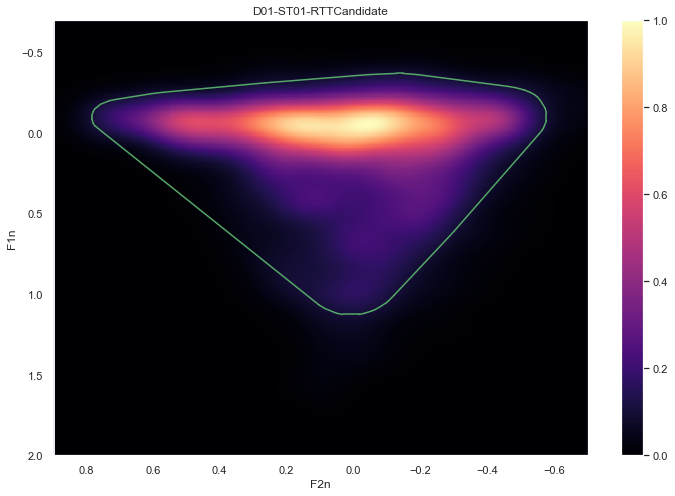

In [15]:
plot_vsd(formants1["F1n"], formants1["F2n"], file1_title, True, 0.1, False, True)

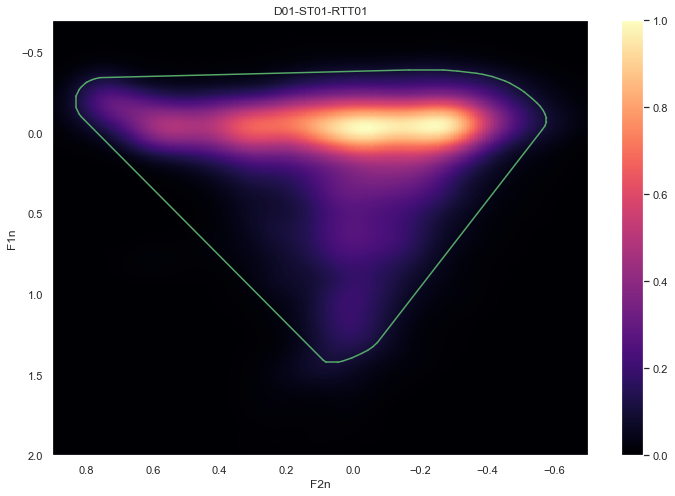

In [16]:
plot_vsd(formants2["F1n"], formants2["F2n"], file2_title, True, 0.1, False, True)

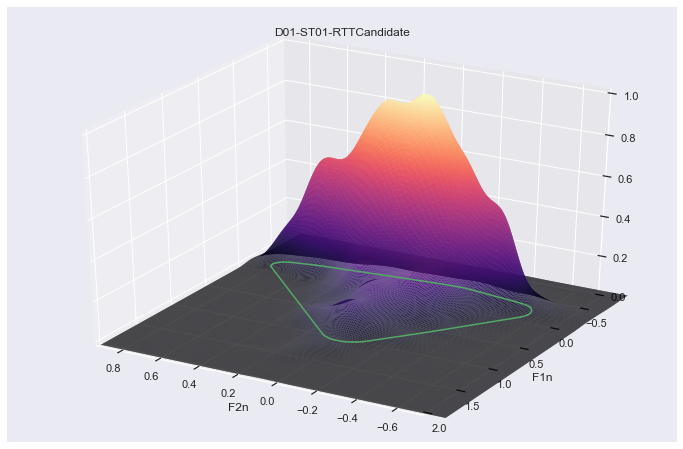

In [17]:
plot_vsd(formants1["F1n"], formants1["F2n"], file1_title, True, 0.1, True, True)

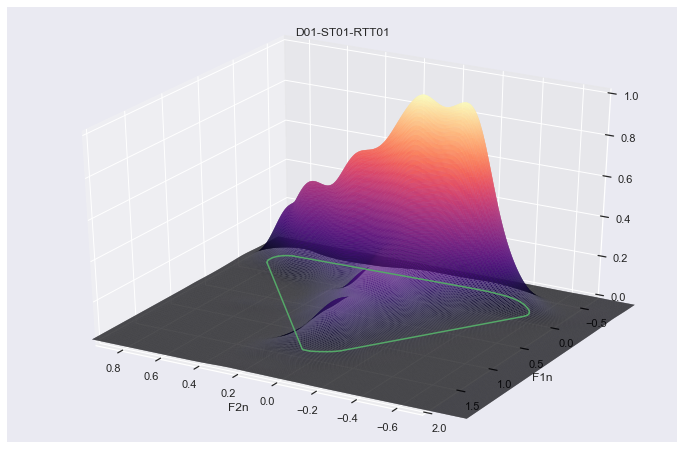

In [18]:
plot_vsd(formants2["F1n"], formants2["F2n"], file2_title, True, 0.1, True, True)

This is interesting! The overall area that gets used seems to be very similar based just on a visual comparison, but the peaks are certainly different. It would be good to actually calculate the hull area for these two samples, or find a way to show more clearly that the peaks are at different positions in the formant space, or even plot the two hulls and compare their shape.

<h2>Convex hull</h2>
Lastly, this just documents the procedure I worked through to get the hull calculation to be at P=0.2 (or any arbitrary value), rather than including all data points. Start by looking at what these nparrays actually are:

In [12]:
#xi
xi.shape
#yi
#zi
#zi.min()
#zi.max()

(400, 400)

The use of <code>mgrid</code> to generate <code>xi</code> and <code>yi</code> is a way to get the effect of a loop over all x and y points in a grid, without actually running a loop. The nparray <code>xi</code> goes through the x values of an <code>nbins * nbins</code> grid, and <code>yi</code> goes through the y values of an <code>nbins * nbins</code> grid. The nparray <code>zi</code> is a one-domensional array which, when you shape it like <code>xi</code> (not <code>yi</code>, because it's linearly flattened by x-row, not by y-column), gives you all the z values (ie, the values of the probability density function generated from the kernel density estimation)at those points.

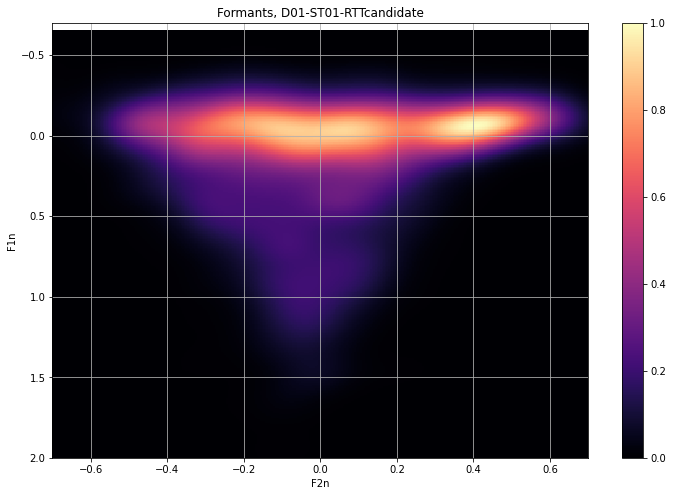

In [13]:
# formants["F2n", "F1n"].plot.kde
fig, ax = plt.subplots()

# Evaluate a gaussian kde on a regular grid of nbins x nbins over data extents
nbins=400
k = kde.gaussian_kde([story1_formants["F2n"],story1_formants["F1n"]])
xi, yi = np.mgrid[story1_formants["F2n"].min():story1_formants["F2n"].max():nbins*1j,
                  story1_formants["F1n"].min():story1_formants["F1n"].max():nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))
znorm = zi / zi.max()
 
# Make the plot
plt.pcolormesh(xi, yi, znorm.reshape(xi.shape), cmap=plt.cm.magma)
plt.colorbar()
ax.set_ylim(2.0, -0.7)  # decreasing F1
ax.set_xlim(-0.7, 0.7)
ax.set(xlabel='F2n', ylabel='F1n',
       title='Formants, D01-ST01-RTTcandidate')
ax.grid()

plt.rcParams['figure.figsize'] = [12, 8]


#fig.savefig("D01-ST01-RTTcandidate.png")
plt.show()

In [14]:
vsd = pd.DataFrame(list(zip(xi.flatten(), yi.flatten(), znorm)),
                  columns=['x', 'y', 'value'])
vsd 

,x,y,value
0,-0.800007,-0.654034,0.000899
1,-0.800007,-0.643788,0.000984
2,-0.800007,-0.633543,0.001073
3,-0.800007,-0.623298,0.001166
4,-0.800007,-0.613053,0.001266
...,...,...,...
159995,0.889830,3.392812,0.000091
159996,0.889830,3.403058,0.000089
159997,0.889830,3.413303,0.000086
159998,0.889830,3.423548,0.000081


In [15]:
filter = vsd['value']>=0.20
vsd_filtered = vsd[filter]

In [16]:
hull = ConvexHull(vsd_filtered[["x","y"]])

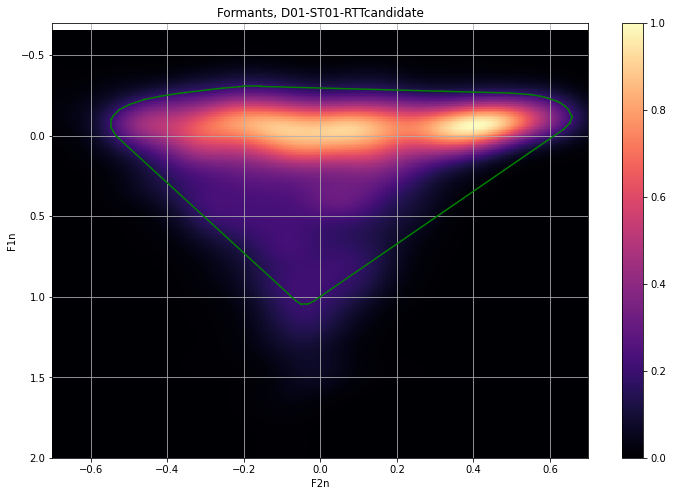

In [17]:
fig, ax = plt.subplots()
plt.pcolormesh(xi, yi, znorm.reshape(xi.shape), cmap=plt.cm.magma)
plt.colorbar()
ax.set_ylim(2.0, -0.7)  # decreasing F1
ax.set_xlim(-0.7, 0.7)
ax.set(xlabel='F2n', ylabel='F1n',
       title='Formants, D01-ST01-RTTcandidate')
ax.grid()
plt.rcParams['figure.figsize'] = [12, 8]

for simplex in hull.simplices:
    plt.plot(vsd_filtered["x"].iloc[simplex], vsd_filtered["y"].iloc[simplex], 'g-')

plt.show()